In [1]:
import pickle
import numpy as np
from scipy.spatial import distance
from joblib import load
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
def precision(real, pred, positive_class=1):
    TP = ((real == positive_class) & (pred == positive_class)).sum()
    classed_positive = (pred == positive_class).sum()
    if classed_positive == 0:
        precision = 1
    else:
        precision = TP/classed_positive
    
    return precision

def recall(real, pred, positive_class=1):
    TP = ((real == positive_class) & (pred == positive_class)).sum()
    recall = TP/(real == positive_class).sum()
    
    return recall

def f1(real, pred, positive_class=1):
    prec = precision(real, pred, positive_class)
    rec = recall(real, pred, positive_class)
    f1 = 2*(prec*rec)/(prec+rec)
    
    return f1, prec, rec

In [3]:
 with open("../code/embedding/models/doc_data/id_dict.txt", "rb") as fp:
    id_dict = pickle.load(fp)
# Unpickle the document data
with open("../code/embedding/models/doc_data/all_docs.txt", "rb") as fp:
    all_docs = pickle.load(fp)
with open("../code/embedding/models/doc_data/all_docs_sep.pkl", "rb") as fp:
    all_docs_sep = pickle.load(fp)
with open("../code/embedding/models/doc_data/ticket_ids.txt", "rb") as fp:
    ticket_ids = pickle.load(fp)

faq_ans = all_docs_sep['faq_ans']
ticket_ques = all_docs_sep['ticket_ques']

# Load the labelled data
labelled_data = pd.read_csv('../data/labelled_dat/train.csv')
labelled_data['is_faq'] = (labelled_data.faq_id != -1).astype(int)

In [18]:
TFiDF = load('../code/embedding/models/TF-IFD-ticket-ques.joblib')

# make matrix
FAQ_matrix = TFiDF.transform(faq_ans)
ticket_matrix = TFiDF.transform(ticket_ques)
print('Computing TF-IDF Similarities...')
sim_matrix = cosine_similarity(FAQ_matrix, ticket_matrix)
print('Computed')

# mapping
FAQ_per_ticket = np.argmax(sim_matrix, axis=0)

# Using Closest FAQ similarity as a measure 
strength_FAQ_ticket_max = np.max(sim_matrix, axis=0)

# Checking if the mean is a better measure of whether something is an FAQ or not
# get mean of closest 5 similarities
strength_FAQ_ticket_mean5 = np.flip(np.sort(sim_matrix, axis=0), axis=0)[0:5,:].mean(axis=0)
# Result: no real improvement

strength_FAQ_ticket_std5 = np.flip(np.sort(sim_matrix, axis=0), axis=0)[0:5,:].std(axis=0)


Computing TF-IDF Similarities...
Computed


In [22]:
feature_value = strength_FAQ_ticket_max

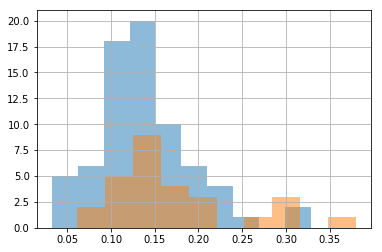

In [23]:
# Figuring out if the stregth measure is any good
feature_values = pd.DataFrame({'ticket_id': ticket_ids, 'value': feature_value})
feature_values.set_index('ticket_id', drop=False, inplace=True)
full_feature_dat = labelled_data.join(feature_values, on='ticket_id', lsuffix='l_')
full_feature_dat.groupby('is_faq').value.hist(alpha=0.5)
plt.show()

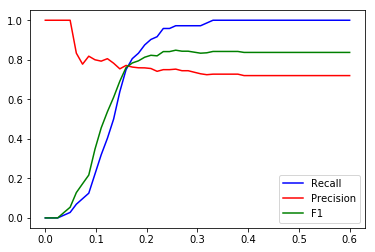

In [7]:
threshes = np.linspace(0,0.6, 50)
precs, recs, f1s = [], [], []
positive_class = 0

for thresh in threshes:
    # assign weak mappings to -1
    FAQ_per_ticket_threshold = FAQ_per_ticket.copy()
    FAQ_per_ticket_threshold[feature_value < thresh] = -1
    
    predictions = pd.DataFrame({'ticket_id': ticket_ids, 'faq_id_pred': FAQ_per_ticket_threshold})
    predictions['is_faq_pred'] = (predictions.faq_id_pred != -1).astype(int)
    predictions.set_index('ticket_id', drop=False, inplace=True)
    full_dat = labelled_data.join(predictions, on='ticket_id', lsuffix='l_')
    
    f1_, prec, rec = f1(full_dat.is_faq, full_dat.is_faq_pred, positive_class=positive_class)
    precs.append(prec)
    recs.append(rec)
    f1s.append(f1_)
    
plt.plot(threshes, recs, color = 'blue', label="Recall")
plt.plot(threshes, precs, color = 'red', label="Precision")
plt.plot(threshes, f1s, color='green', label="F1")
plt.legend()
plt.show()